# Imports

In [1]:
import os
from os.path import join as pjoin

import cv2
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import ReduceLROnPlateau

import segmentation_models_pytorch as smp

import torchmetrics.classification as metrics

import torchvision
from torchvision import transforms

from torch.utils.tensorboard import SummaryWriter

import albumentations as A
from albumentations.pytorch import ToTensorV2

from tqdm.notebook import tqdm
import torchinfo

import matplotlib.pyplot as plt

from additonFunc import uniqufy_path, create_image_plot, save_imgs

# Иницилизация ключевых значений

In [2]:
LAUNCH_NAME = "MyUnet_FixedSet"

STARTING_EPOCH = 0
LOAD_WEIGHTS = None #
LOAD_ADAM_STATE = None #
USE_MANUAL_TENSORBOARD_FOLDER = None #

LOAD_TEST_WEIGHTS = "/home/sega/progs/AI_Tasks/02_Task/TB_cache/roads_2/weights_last.pth" #

EPOCHS = 50
LEARNING_RATE = 0.001

BATCH_SIZE = 20

WEIGHT_SAVER = "last" # "all" / "nothing" / "last"

CLASS_NAMES = ['other', 'road']
CLASS_RGB_VALUES = [[0,0,0], [255, 255, 255]]

NORMALIZE_MEAN_IMG = [0.4295, 0.4325, 0.3961]
NORMALIZE_DEVIATIONS_IMG = [0.2267, 0.2192, 0.2240]

CROP_SIZE = (256, 256)
PADDED_SIZE = (1536, 1536)

NUM_WORKERS = 4
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

DATASET_DIR = 'dataset/tiff'
VALID_SET   = (pjoin(DATASET_DIR, "val"), pjoin(DATASET_DIR, "val_labels"))
TEST_SET   =  (pjoin(DATASET_DIR, "test"), pjoin(DATASET_DIR, "test_labels"))
TRAIN_SET   = (pjoin(DATASET_DIR, "train"), pjoin(DATASET_DIR, "train_labels"))

trained = False

In [3]:
TBpath = uniqufy_path(f"TB_cache/{LAUNCH_NAME}") if USE_MANUAL_TENSORBOARD_FOLDER is None else USE_MANUAL_TENSORBOARD_FOLDER
TBwriter = SummaryWriter(TBpath)

# Transform's 

In [4]:
def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')

prepare_to_network = A.Lambda(image=to_tensor, mask=to_tensor)

train_transform = A.Compose(
    [
        A.RandomCrop(*CROP_SIZE, always_apply=True),
        A.OneOf(
            [
                A.HorizontalFlip(p=1),
                A.VerticalFlip(p=1),
                A.RandomRotate90(p=1),
            ],
            p=0.75,
        ),
        A.Normalize(mean=NORMALIZE_MEAN_IMG, std=NORMALIZE_DEVIATIONS_IMG, always_apply=True)
    ]
)


valid_transform = A.Compose(
    [
        A.Normalize(mean=NORMALIZE_MEAN_IMG, std=NORMALIZE_DEVIATIONS_IMG, always_apply=True),
    ]
)

In [5]:
def one_hot_encode(label, label_values):
    semantic_map = []
    for colour in label_values:
        equality = np.equal(label, colour)
        class_map = np.all(equality, axis = -1)
        semantic_map.append(class_map)
    semantic_map = np.stack(semantic_map, axis=-1)
    return semantic_map

def reverse_one_hot(image):
    x = np.argmax(image, axis = -1)
    return x

def colour_code_segmentation(image, label_values):
    colour_codes = np.array(label_values)
    x = colour_codes[image.astype(int)]
    return x

# Dataset's


In [6]:
class RoadsDataset(Dataset):
    def __init__(self, values_dir, labels_dir, class_rgb_values=None, transform=None, readyToNetwork=None):
        self.values_dir = values_dir
        self.labels_dir = labels_dir
        self.class_rgb_values = class_rgb_values
        self.images = [pjoin(self.values_dir, filename) for filename in sorted(os.listdir(self.values_dir))]
        self.labels = [pjoin(self.labels_dir, filename) for filename in sorted(os.listdir(self.labels_dir))]
        self.transform = transform
        self.readyToNetwork = readyToNetwork

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image_path = self.images[index]
        label_path = self.labels[index]

        image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
        label = cv2.cvtColor(cv2.imread(label_path), cv2.COLOR_BGR2RGB)
        label = one_hot_encode(label, self.class_rgb_values).astype('float')

        if self.transform:
            sample = self.transform(image=image, mask=label)
            image, label = sample['image'], sample['mask']
        if self.readyToNetwork:
            sample = self.readyToNetwork(image=image, mask=label)
            image, label = sample['image'], sample['mask']
        return image, label

In [7]:
sample_dataset = RoadsDataset(*TEST_SET,
                       class_rgb_values=CLASS_RGB_VALUES, transform=train_transform)

for i in range(10):
    image, mask = sample_dataset[np.random.randint(0, len(sample_dataset))]
    TBwriter.add_figure(f'train samples', create_image_plot(origin=image, true=colour_code_segmentation(
        reverse_one_hot(mask), CLASS_RGB_VALUES)), global_step=i)
del(sample_dataset)

# Model

In [8]:
class ConvBlock(nn.Module):
    def __init__(self, inC : int, outC : int, kernel_size, **kwargs) -> None:
        super().__init__()
        if isinstance(kernel_size, int):
            kernel_size = (kernel_size, kernel_size)
        self.in_channels = inC
        self.out_channels = outC
        self.kernel_size = kernel_size
        self.conv = nn.Conv2d(inC, outC, kernel_size, **kwargs)
        self.bn = nn.BatchNorm2d(outC)
        self.activation = nn.ReLU(True)
    
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        return self.activation(x)

class DeConvBlock(nn.Module):
    def __init__(self, inC : int, outC : int, kernel_size, **kwargs) -> None:
        super().__init__()
        if isinstance(kernel_size, int):
            kernel_size = (kernel_size, kernel_size)
        self.in_channels = inC
        self.out_channels = outC
        self.kernel_size = kernel_size
        self.conv = nn.ConvTranspose2d(inC, outC, kernel_size, **kwargs)
        self.bn = nn.BatchNorm2d(outC)
        self.activation = nn.ReLU(True)
    
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        return self.activation(x)

class ResidualBlock(nn.Module):
    def __init__(self, inC, outC = 0, interC = -1, block_expansion = 4):
        super().__init__()
        self.block_expansion = block_expansion

        self.downConv = None
        self.upConv = None

        if interC > 0:
            self.downConv = ConvBlock(inC, interC, 1)
        elif interC < 0:
            if interC == -1:
                interC = inC * self.block_expansion
            else:
                interC = inC * -interC
            self.downConv = ConvBlock(inC, interC, 1)
        else:
            interC = inC

        self.mainConv = ConvBlock(interC, interC, 3, padding=1, groups=interC)

        if outC > 0:
            self.upConv = ConvBlock(interC, outC, 1)
        
    def forward(self, x):
        if self.downConv:
            x = self.downConv(x)
        x = self.mainConv(x)
        if self.upConv:
            x = self.upConv(x)
        return x

class ResidualStepBlock(nn.Module):
    def __init__(self, inC, outC, global_block_expansion, interSize = 4, inter_block_expansion = 2):
        super().__init__()

        _innerConvs = []
        previousC = inC
        for stepC in range(inC, outC, (outC-inC)//interSize):
            _innerConvs.append(ResidualBlock(previousC, stepC, block_expansion=inter_block_expansion))
            previousC = stepC
        _innerConvs.append(ResidualBlock(previousC, outC, block_expansion=inter_block_expansion))
        
        self.innerConvs = nn.Sequential(*_innerConvs)
        if global_block_expansion > 0:
            self.spatialConv = ConvBlock(outC, outC, 3, stride=global_block_expansion, padding=1)
        else:
            self.spatialConv = DeConvBlock(outC, outC, 4, stride=-global_block_expansion, padding=1)
    
    def forward(self, x):
        x = self.innerConvs(x)
        x = self.spatialConv(x)
        return x

class MyEncoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv_1 = ConvBlock(3, 64, 3, stride=4, padding=1)

        self.conv_2_residual = ResidualStepBlock(64, 96, global_block_expansion=2, interSize=2)

        self.conv_3_residual = ResidualStepBlock(96, 128, global_block_expansion=2, interSize=4)

        self.conv_4_residual = ResidualStepBlock(128, 256, global_block_expansion=2, interSize=4)

        self.conv_5_residual = ResidualStepBlock(256, 512, global_block_expansion=2, interSize=8)


    def forward(self, x):
        xs = [x]
        xs.append(self.conv_1(xs[-1]))
        xs.append(self.conv_2_residual(xs[-1]))
        xs.append(self.conv_3_residual(xs[-1]))
        xs.append(self.conv_4_residual(xs[-1]))
        xs.append(self.conv_5_residual(xs[-1]))
        return xs

class MyDecoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.deconv_1_residual = ResidualStepBlock(512, 256, global_block_expansion=-2, interSize=8)

        self.deconv_2_residual = ResidualStepBlock(256, 128, global_block_expansion=-2, interSize=4)

        self.deconv_3_residual = ResidualStepBlock(128, 96, global_block_expansion=-2, interSize=4)

        self.deconv_4_residual = ResidualStepBlock(96, 64, global_block_expansion=-2, interSize=2)

        self.deconv_5 = DeConvBlock(64, 3, 4, stride=4)
    
    def forward(self, encoder_samples):
        x = self.deconv_1_residual(encoder_samples[-1]) + encoder_samples[-2]
        x = self.deconv_2_residual(x) + encoder_samples[-3]
        x = self.deconv_3_residual(x) + encoder_samples[-4]
        x = self.deconv_4_residual(x) + encoder_samples[-5]
        x = self.deconv_5(x)
        return x


class MyUnet(nn.Module):
    def __init__(self, outClasses : int):
        super().__init__()

        self.encoder = MyEncoder()
        self.decoder = MyDecoder()

        self.classificator = ConvBlock(3, outClasses, 3, padding=1)

    def forward(self, x):
        encoder_xs = self.encoder(x)
        x = self.decoder(encoder_xs)
        x = self.classificator(x)
        return x

In [9]:
model = MyUnet(2)
# ENCODER = 'timm-mobilenetv3_large_100'
# CLASSES = CLASS_NAMES
# ACTIVATION = nn.ReLU

# model = smp.Unet(
#     encoder_name=ENCODER, 
#     classes=len(CLASSES), 
#     activation=ACTIVATION,
# )

# print(model_sum := torchinfo.summary(model, depth=3, input_size=(BATCH_SIZE, 3, *CROP_SIZE), row_settings=["var_names"], verbose=0, col_names=[
#       "input_size", "output_size", "num_params", "params_percent", "kernel_size", "mult_adds", "trainable"]))

# dummy_input = torch.randn(1, 3, *CROP_SIZE)
# torch.onnx.export(
#             model.cpu(),
#             dummy_input,
#             "model.onnx",
#         )

# Dataloader's 

In [10]:
train_dataset = RoadsDataset(*TRAIN_SET,
                       class_rgb_values=CLASS_RGB_VALUES, transform=train_transform, readyToNetwork=prepare_to_network)
valid_dataset = RoadsDataset(*VALID_SET,
                       class_rgb_values=CLASS_RGB_VALUES, transform=valid_transform, readyToNetwork=prepare_to_network)

train_dataloader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
)
valid_dataloader = DataLoader(
    valid_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
)

In [11]:
images, _ = next(iter(valid_dataloader))
TBwriter.add_graph(model, images)

model = model.to(DEVICE)
print(model_sum := torchinfo.summary(model, input_size=(BATCH_SIZE, 3, *CROP_SIZE), row_settings=["var_names"], verbose=0, col_names=[
      "input_size", "output_size", "num_params", "params_percent", "kernel_size", "mult_adds", "trainable"]))

Layer (type (var_name))                            Input Shape               Output Shape              Param #                   Param %                   Kernel Shape              Mult-Adds                 Trainable
MyUnet (MyUnet)                                    [20, 3, 256, 256]         [20, 2, 256, 256]         --                             --                   --                        --                        True
├─MyEncoder (encoder)                              [20, 3, 256, 256]         [20, 3, 256, 256]         --                             --                   --                        --                        True
│    └─ConvBlock (conv_1)                          [20, 3, 256, 256]         [20, 64, 64, 64]          --                             --                   [3, 3]                    --                        True
│    │    └─Conv2d (conv)                          [20, 3, 256, 256]         [20, 64, 64, 64]          1,792                       0.01%           

/home/sega/progs/AI_Tasks/AIenv/lib/python3.10/site-packages/torchinfo/torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),
/home/sega/progs/AI_Tasks/AIenv/lib/python3.10/site-packages/torch/storage.py:665: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return super().__sizeof__() + self.nbytes()


# Optimizer's

In [12]:
loss = smp.losses.DiceLoss(mode='binary')

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=0.00001)

scheduler = ReduceLROnPlateau(optimizer, 'min', patience=3, threshold=1e-3, cooldown=1, factor=0.5)

# Шаги обучения

In [13]:
def train_step(net, criterion, optimizer, dataloader, epoch: int = None):
    net.train()
    running_loss = 0.
    for images, labels in dataloader:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        optimizer.zero_grad()

        output = net(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss

    with torch.no_grad():
        train_loss = running_loss / len(dataloader)
    return train_loss.item()


def valid_step(net, criterion, dataloader, epoch: int = None):
    net.eval()
    running_loss = 0.
    IoU = metrics.BinaryJaccardIndex()
    IoU.to(DEVICE)

    with torch.no_grad():
        for step, (images, labels) in enumerate(dataloader):
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)

            output = net(images)

            IoU(output, labels)
            loss = criterion(output, labels)
            running_loss += loss

            save_imgs(pjoin(TBpath, f"valid_samples/samples_{epoch}"), name=f"img_{step}",
                origin=images[0].cpu().numpy().transpose(2, 1, 0),
                true=colour_code_segmentation(reverse_one_hot(
                    labels[0].cpu().numpy().transpose(2, 1, 0)), CLASS_RGB_VALUES),
                pred=colour_code_segmentation(reverse_one_hot(
                    output[0].cpu().numpy().transpose(2, 1, 0)), CLASS_RGB_VALUES))

        TBwriter.add_figure('valid_sample', create_image_plot(
                origin=images[0].cpu().numpy().transpose(2, 1, 0),
                true=colour_code_segmentation(reverse_one_hot(
                    labels[0].cpu().numpy().transpose(2, 1, 0)), CLASS_RGB_VALUES),
                pred=colour_code_segmentation(reverse_one_hot(
                    output[0].cpu().numpy().transpose(2, 1, 0)), CLASS_RGB_VALUES)),
                  epoch)

        valid_loss = running_loss / len(valid_dataloader)

        return valid_loss.item(), IoU.compute().item()


In [14]:
epoch = STARTING_EPOCH


In [15]:
if LOAD_WEIGHTS is not None:
    model.state_dict(torch.load(LOAD_WEIGHTS))
if LOAD_ADAM_STATE is not None:
    optimizer.load_state_dict(torch.load(LOAD_ADAM_STATE))
    
None

# Цикл обучения

In [16]:
best_loss = 10000
trained = True

pbar = tqdm(range(EPOCHS))
pbar.update(epoch)

while(epoch < EPOCHS):
    train_loss = train_step(model, loss, optimizer, train_dataloader, epoch)
    valid_loss, iou_score = valid_step(model, loss, valid_dataloader, epoch)
    scheduler.step(valid_loss)

    if WEIGHT_SAVER != "nothing" and valid_loss < best_loss and epoch > 3:
        best_loss = valid_loss

        print(f"[{epoch}] Saved weights with IoU: {iou_score:.2f} | loss: {valid_loss:.4f}")
    
        if WEIGHT_SAVER == "all":
            torch.save(optimizer.state_dict(), f"{TBpath}/optimizer_{epoch}.pth")
            torch.save(model.state_dict(), f"{TBpath}/weights_{epoch}.pth")
        elif WEIGHT_SAVER == "last":
            torch.save(optimizer.state_dict(), f"{TBpath}/optimizer_last.pth")
            torch.save(model.state_dict(), f"{TBpath}/weights_last.pth")

    TBwriter.add_scalar('valid loss', valid_loss, epoch)
    TBwriter.add_scalar('train loss', train_loss, epoch)
    
    TBwriter.add_scalar('IoU', iou_score, epoch)

    for i, param_group in enumerate(optimizer.param_groups):
        TBwriter.add_scalar('learning rate', float(param_group['lr']), epoch)

    epoch += 1
    pbar.update()
    pbar.set_description(
        f'IoU: {iou_score:.2f}  | train/valid loss: {train_loss:.4f}/{valid_loss:.4f}')


  0%|          | 0/50 [00:00<?, ?it/s]

# Тестирование

In [ ]:
test_transform = A.Compose(
    [
        A.Normalize(mean=NORMALIZE_MEAN_IMG, std=NORMALIZE_DEVIATIONS_IMG, always_apply=True),
    ]
)

test_dataset = RoadsDataset(*TEST_SET,
       class_rgb_values=CLASS_RGB_VALUES, transform=test_transform, readyToNetwork=prepare_to_network)
test_dataloader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
)
if not trained:
    print(f"Используется не обученая модель, происходит импорто весов из {LOAD_TEST_WEIGHTS}")
    model = MyUnet(2)
    model.state_dict(torch.load(f=LOAD_TEST_WEIGHTS))
    model.to(DEVICE)

Используется не обученая модель, происходит импорто весов из /home/sega/progs/AI_Tasks/02_Task/TB_cache/roads_2/weights_last.pth


In [ ]:
TEST_METRIC = metrics.MulticlassStatScores(num_classes=2, average=None)

In [ ]:
def saveDivide(x, y): return torch.nan_to_num(x/y)

def calculate_metric_by_errors(numerator, denominator, classes):
    with torch.no_grad():
        metric_values = saveDivide(numerator, denominator)
        metric_per_class = {classname: val.item()
                            for classname, val in zip(classes, metric_values)}
        metric_average = torch.sum(metric_values)/len(classes)
        metric_average_micro = saveDivide(torch.sum(numerator), torch.sum(denominator))
        return (metric_values, metric_per_class, metric_average, metric_average_micro)

def test_step(model, loader, metric : metrics.MulticlassStatScores):
    classes = CLASS_NAMES
    metric.to(DEVICE)

    with torch.no_grad():
        model.eval()
        for id, (images, labels) in enumerate(loader):
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)
            output = model(images)
            TBwriter.add_figure('test_sample', create_image_plot(
                origin=images[0].cpu().numpy().transpose(2, 1, 0),
                true=colour_code_segmentation(reverse_one_hot(
                    labels[0].cpu().numpy().transpose(2, 1, 0)), CLASS_RGB_VALUES),
                pred=colour_code_segmentation(reverse_one_hot(
                    output[0].cpu().numpy().transpose(2, 1, 0)), CLASS_RGB_VALUES)),
                  id)
            metric.update(output, labels)

    tp, fp, tn, fn = metric._final_state()

    acc = calculate_metric_by_errors((tp+tn), (tp+fp+tn+fn), classes=classes)
    rec = calculate_metric_by_errors(tp, (tp+fn), classes=classes)
    prec = calculate_metric_by_errors(tp, (tp+fp), classes=classes)

    jaccard = calculate_metric_by_errors(tp, (tp+fp+fn), classes=classes)
    dice = calculate_metric_by_errors(2*tp, 2*tp+tn+tp, classes=classes)

    metric_values = {
        "accuracy": acc,
        "recall": rec,
        "precision": prec,
        "jaccard": jaccard,
        "dice": dice
    }

    return metric_values

In [ ]:
metric_values = test_step(model, test_dataloader, TEST_METRIC)

In [ ]:
print(metric_values["jaccard"][0])

tensor([0.5000, 0.0000], device='cuda:0')


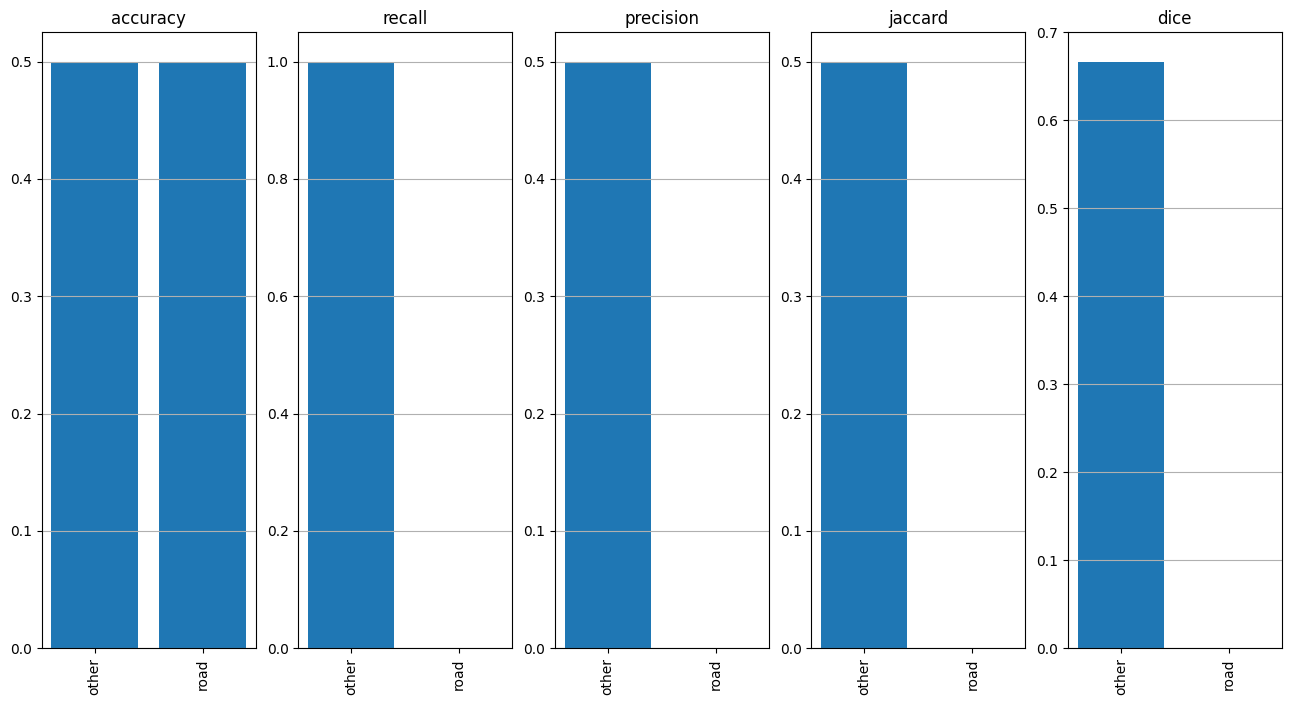

accuracy:
    	macro: 0.500
    	micro: 0.500
recall:
    	macro: 0.500
    	micro: 0.500
precision:
    	macro: 0.250
    	micro: 0.500
jaccard:
    	macro: 0.250
    	micro: 0.333
dice:
    	macro: 0.333
    	micro: 0.500



In [ ]:
metric_count = len(metric_values)

fig, axes = plt.subplots(1, metric_count, figsize=(16,8))

result_string = ""

for (metricName, mValues), ax in zip(metric_values.items(), axes):
    result_string += f"""{metricName}:
    \tmacro: {mValues[2]:.3f}
    \tmicro: {mValues[3]:.3f}\n"""
    mVal = mValues[1]
    plt.sca(ax)
    plt.bar(mVal.keys(), mVal.values())
    plt.title(metricName)
    plt.grid(axis='y')
    plt.xticks(rotation=90)
plt.show()

print(result_string)

In [ ]:
TBwriter.close()